In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans


from sklearn.decomposition import PCA
from umap_batch import UMAP
from utils import re_nn_distance, re_distance_nn

import pandas as pd  
import scipy.sparse as sp
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [2]:
dir = '../data/real/ASAP-PBMC/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in range(1,5):
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    try:
        counts_protein = np.array(sp.load_npz(os.path.join(dir, 'PxC' + str(batch) + ".npz")).todense().T)
        counts_protein = utils.preprocess(counts_protein, modality = "RNA")
        
    except:
        counts_protein = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)
    counts_proteins.append(counts_protein)

counts = {"rna":counts_rnas, "atac": counts_atacs, "protein": counts_proteins}

A1 = sp.load_npz(os.path.join(dir, 'GxP.npz'))
A2 = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A1 = np.array(A1.todense())
A2 = np.array(A2.todense())
A1 = utils.preprocess(A1, modality = "gact")
A2 = utils.preprocess(A2, modality = "gact")

interacts = {"rna_atac": A2, "rna_protein": A1}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()
proteins = pd.read_csv(dir + "proteins.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions, "protein": proteins}
counts["feats_name"] = feats_name

In [3]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 5]
batchsize = 0.1
run = 0
# better with 13

K = 30
Ns = [K] * 4
N_feat = K

# K = 8
# Ns = [K] * 4
# N_feat = 8
interval = 100
T = 6000
lr = 1e-2

# didn't use the interaction matrix
model1 = model.cfrm_vanilla(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)

Input sanity check...
Finished.
Epoch 100, Validating Loss: 166.7778
	 loss 1: 0.16669
	 loss 2: 0.08593
	 loss 3: 0.00000
Epoch 200, Validating Loss: 163.8890
	 loss 1: 0.16389
	 loss 2: 0.00117
	 loss 3: 0.00000
Epoch 300, Validating Loss: 159.5264
	 loss 1: 0.15952
	 loss 2: 0.00240
	 loss 3: 0.00000
Epoch 400, Validating Loss: 156.0252
	 loss 1: 0.15602
	 loss 2: 0.00159
	 loss 3: 0.00000
Epoch 500, Validating Loss: 153.7196
	 loss 1: 0.15372
	 loss 2: 0.00268
	 loss 3: 0.00000
Epoch 600, Validating Loss: 151.8491
	 loss 1: 0.15184
	 loss 2: 0.00551
	 loss 3: 0.00000
Epoch 700, Validating Loss: 150.4433
	 loss 1: 0.15044
	 loss 2: 0.00589
	 loss 3: 0.00000
Epoch 800, Validating Loss: 149.3504
	 loss 1: 0.14935
	 loss 2: 0.00404
	 loss 3: 0.00000
Epoch 900, Validating Loss: 148.6180
	 loss 1: 0.14861
	 loss 2: 0.00562
	 loss 3: 0.00000
Epoch 1000, Validating Loss: 148.0405
	 loss 1: 0.14803
	 loss 2: 0.00733
	 loss 3: 0.00000
Epoch 1100, Validating Loss: 147.4765
	 loss 1: 0.14747
	

In [6]:
# umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = []
labels = []
prec_labels = []
cfrm_labels = []
for batch in range(0,4):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    cfrm_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

# separate into batches
x_umaps = []
leiden_labels = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
        
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# for batch in range(0,4):
#     z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
#     np.save(file = "./pancreas/cell_factors/C_batch" + str(batch) + ".npy", arr = z)


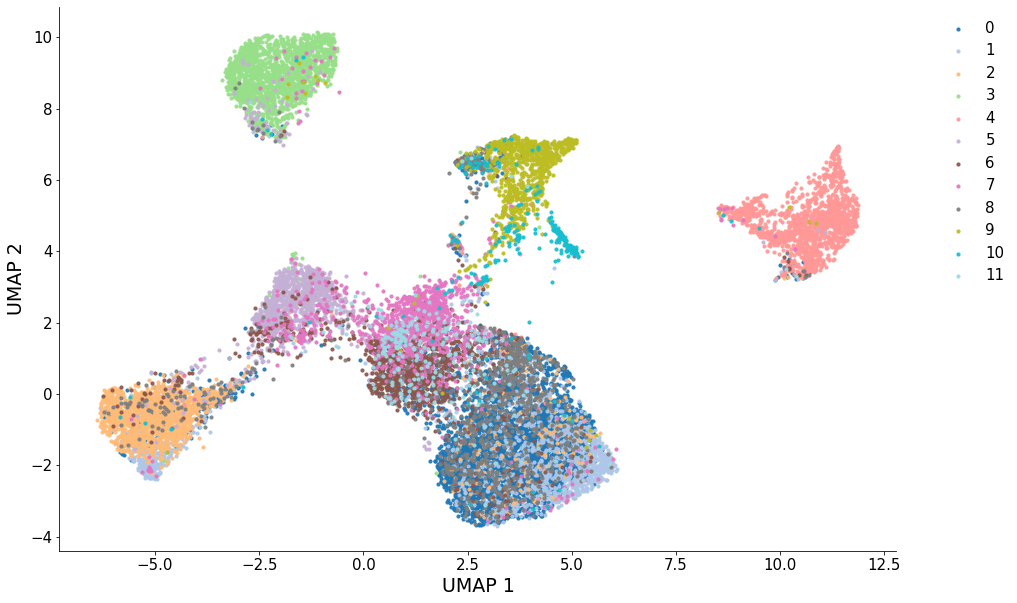

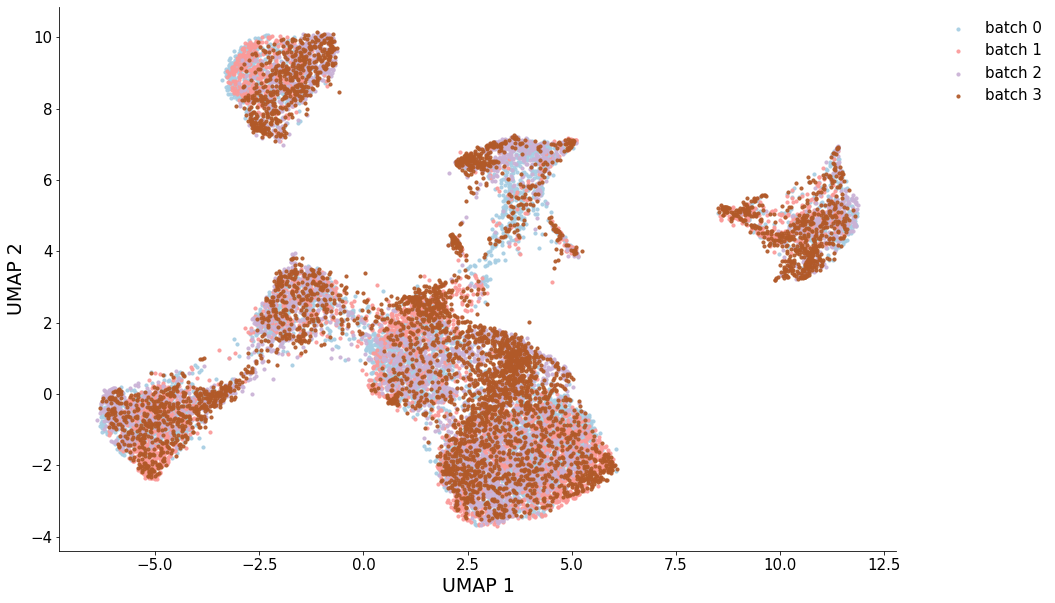

In [8]:
save_file = None
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP")
save_file = None
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP")


## Post-processing -- Method B

../src/umap_batch.py:1746: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


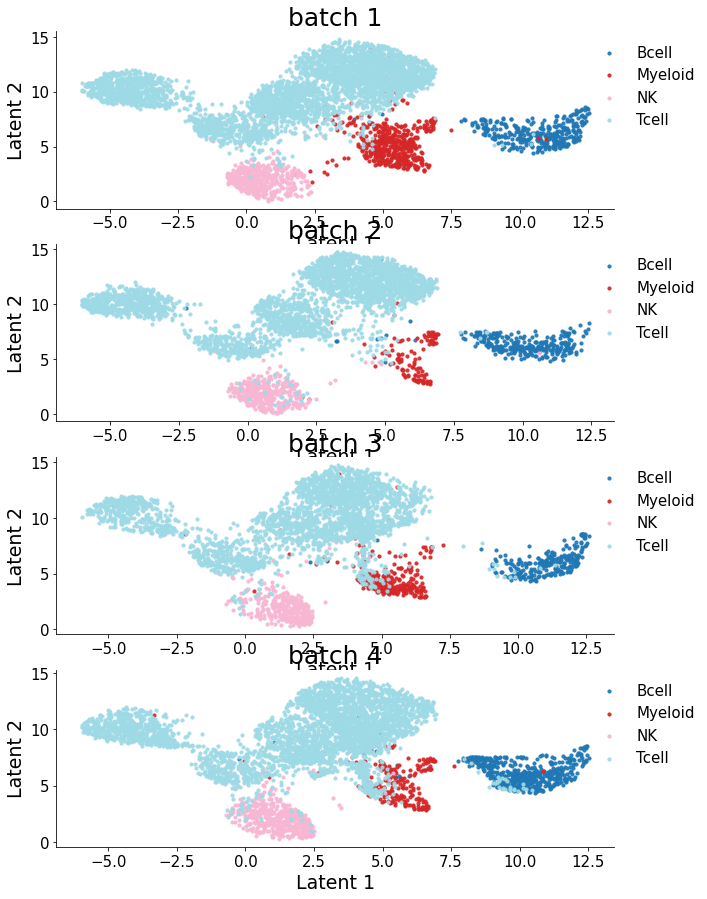

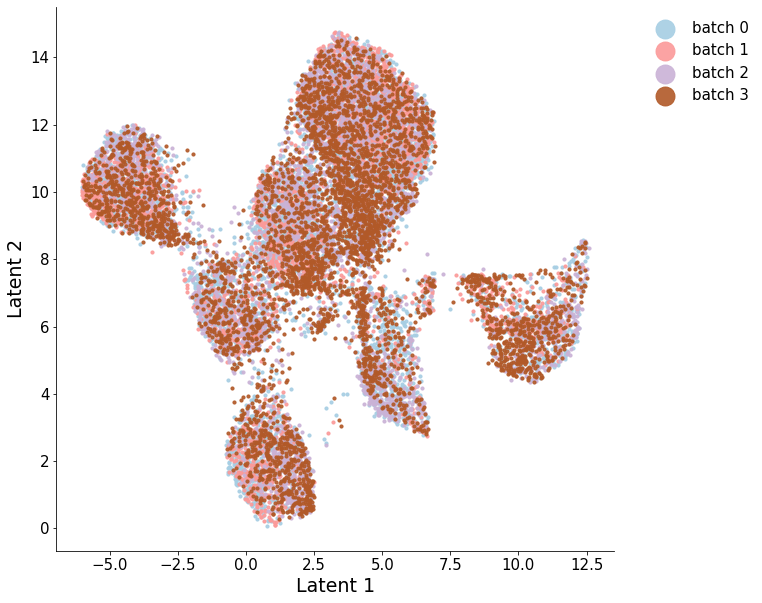

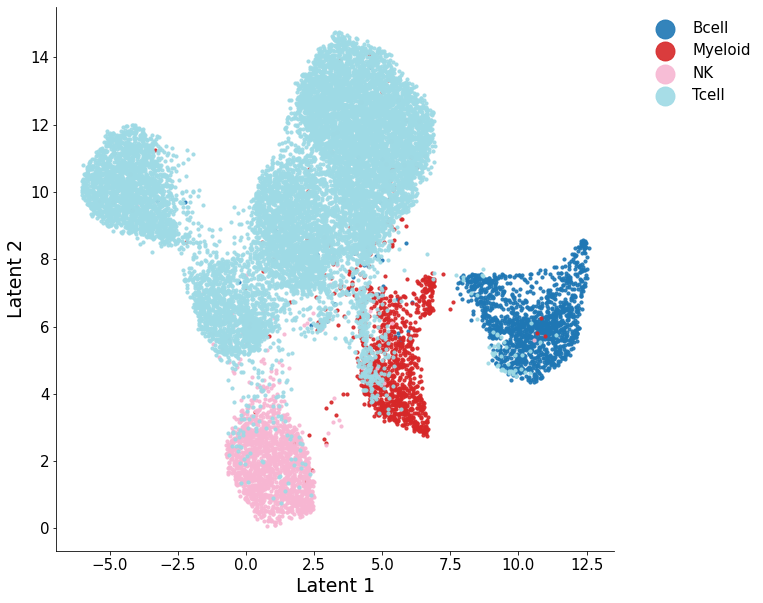

In [23]:
n_neighbors = 10
zs = []
labels = []
prec_labels = []
cfrm_labels = []
for batch in range(0,4):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    cfrm_labels.append(np.argmax(z, axis = 1).squeeze())

s_pair_dist, knn_indices, knn_dists = re_nn_distance(zs, n_neighbors)

umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.4, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (10,10), axis_label = "Latent", markerscale = 6)


## Clustering and retraining

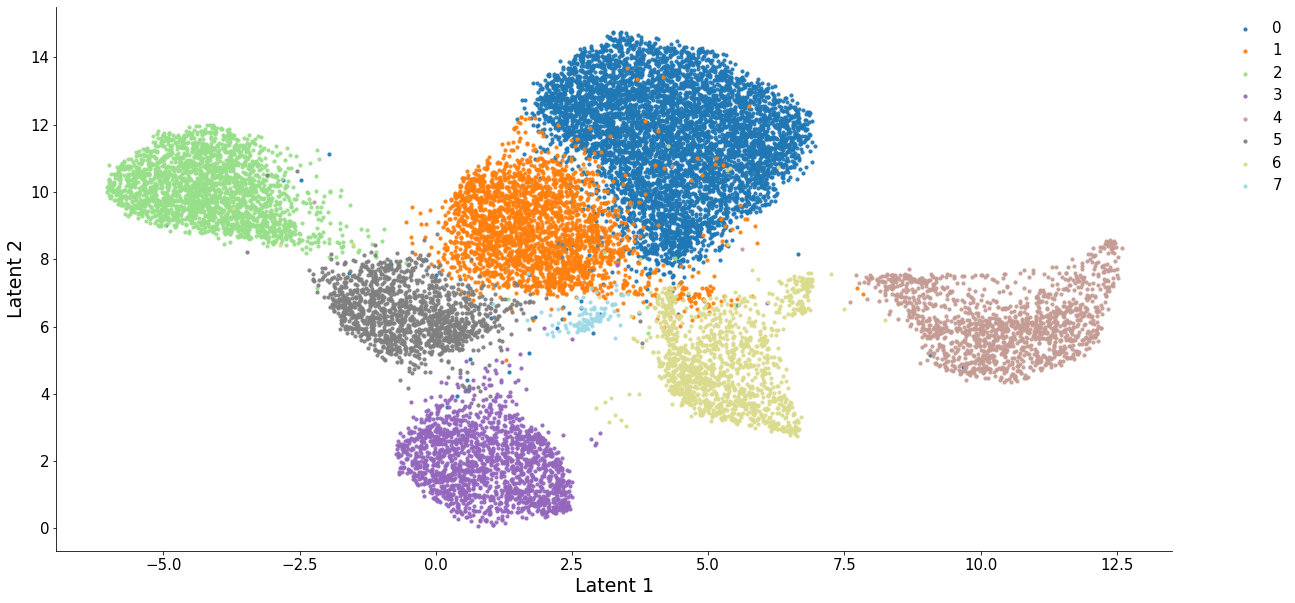

In [24]:
zs = []
labels = []
prec_labels = []
cfrm_labels = []
for batch in range(0,4):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    cfrm_labels.append(np.argmax(z, axis = 1).squeeze())

[s_pair_dist, knn_indices, knn_dists] = re_nn_distance(zs, n_neighbors = 30)
labels_tmp = utils.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = 0.5)

leiden_labels = []
for batch in range(4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])
        
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        leiden_labels.append(labels_tmp[start_pointer:])

    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])

        
for i, x in enumerate(leiden_labels):
#     np.save(arr = x, file = "PBMC/leiden_label_" + str(i) + ".npy")
    leiden_labels[i] = np.load("PBMC/leiden_label_" + str(i) + ".npy")

utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")

In [29]:
model2 = model.cfrm_retrain(model = model1, labels = leiden_labels).to(device)
losses = model2.train(T = 1000)

Epoch 100, Validating Loss: 179.4593
	 loss 1: 0.16183
	 loss 2: 17.62748
	 loss 3: 0.00000
Epoch 200, Validating Loss: 157.6983
	 loss 1: 0.15612
	 loss 2: 1.58116
	 loss 3: 0.00000
Epoch 300, Validating Loss: 154.5414
	 loss 1: 0.15430
	 loss 2: 0.23934
	 loss 3: 0.00000
Epoch 400, Validating Loss: 153.8470
	 loss 1: 0.15375
	 loss 2: 0.09801
	 loss 3: 0.00000
Epoch 500, Validating Loss: 153.6563
	 loss 1: 0.15358
	 loss 2: 0.07342
	 loss 3: 0.00000
Epoch 600, Validating Loss: 153.5057
	 loss 1: 0.15344
	 loss 2: 0.06404
	 loss 3: 0.00000
Epoch 700, Validating Loss: 153.3408
	 loss 1: 0.15329
	 loss 2: 0.05169
	 loss 3: 0.00000
Epoch 800, Validating Loss: 153.2465
	 loss 1: 0.15319
	 loss 2: 0.05688
	 loss 3: 0.00000
Epoch 900, Validating Loss: 153.2406
	 loss 1: 0.15318
	 loss 2: 0.05748
	 loss 3: 0.00000
Epoch 1000, Validating Loss: 153.2732
	 loss 1: 0.15322
	 loss 2: 0.05297
	 loss 3: 0.00000
1


In [30]:
C_feats = {}
for mod in model2.mods:
    C_feat = model2.softmax(model2.C_feats[mod]).data.cpu().numpy() @ model2.A_assos["shared"].data.cpu().numpy().T 
    C_feats[mod] = pd.DataFrame(data = C_feat, index = model2.feats_name[mod], columns = ["cluster_" + str(i) for i in range(C_feat.shape[1])])

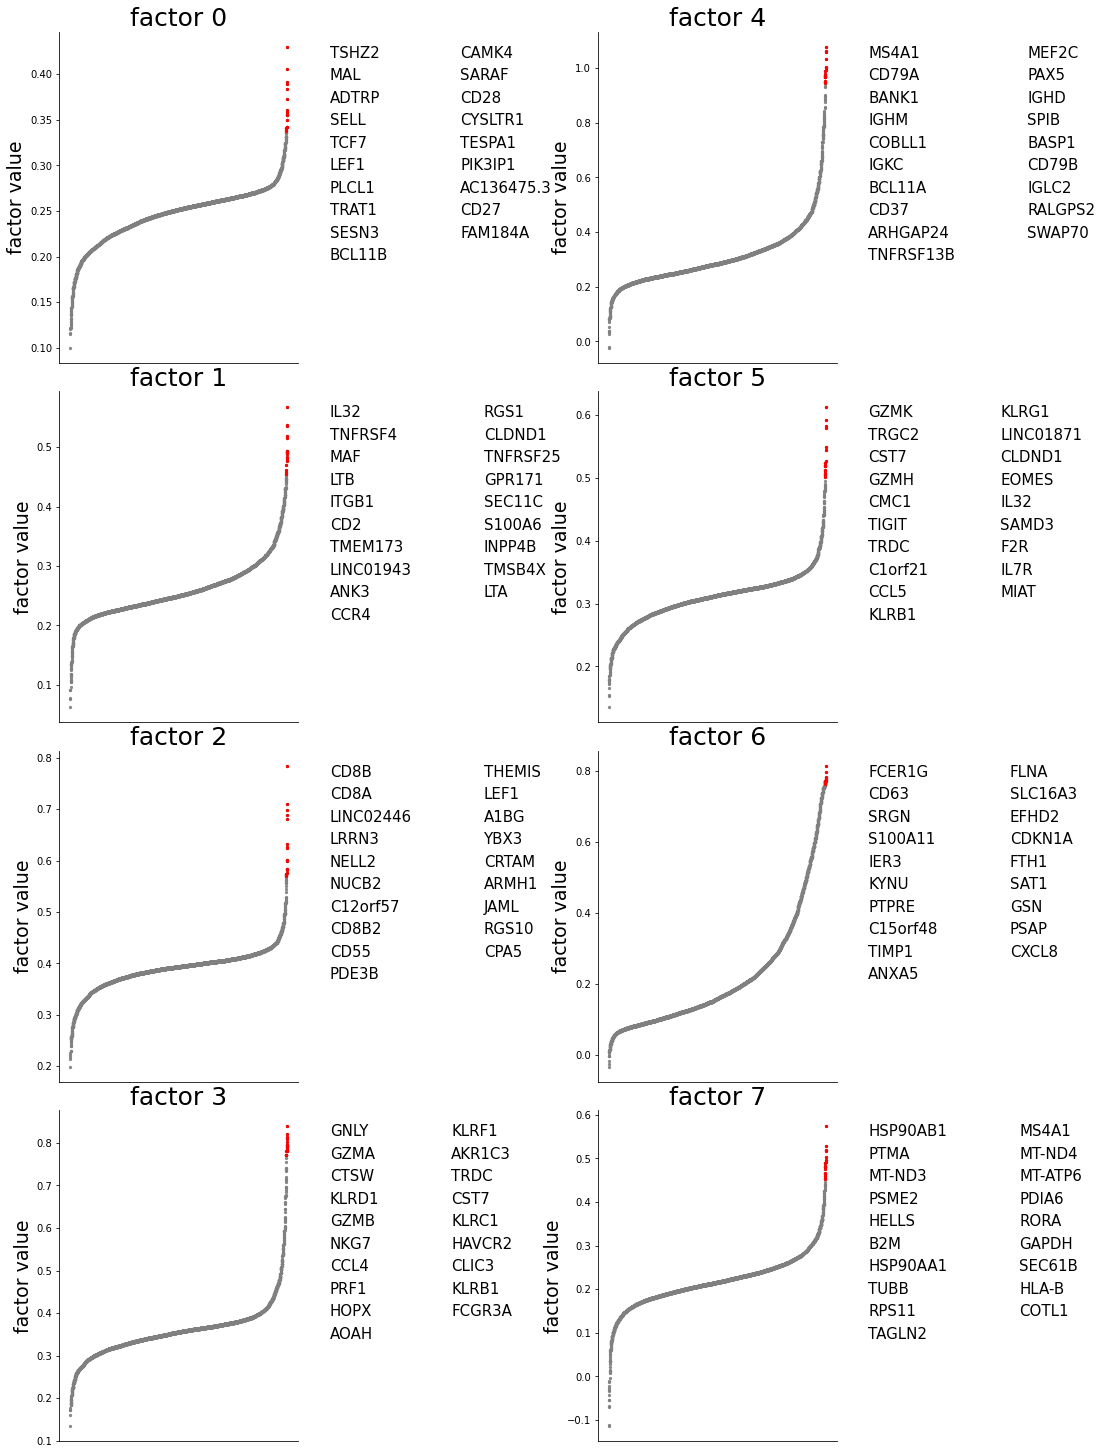

In [31]:
C_gene = C_feats["rna"]
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,20), save_as = None, title = None)


### Check marker genes of NK cells (Cluster 3)

* **GNLY**,NK cells,NK cells,This protein is present in cytotoxic granules of cytotoxic T lymphocytes and natural killer cells, and it has antimicrobial activity against M. tuberculosis and other organisms. 
* **NKG7**,NK cells,NK cells,NKG7 (Natural Killer Cell Granule Protein 7) is a Protein Coding gene. An important paralog of this gene is LIM2.
* **NCAM1**,NK cells,NK cells,This protein is also involved in the expansion of T lymphocytes, B lymphocytes and natural killer (NK) cells which play an important role in immune surveillance.
* **KLRB1**,NK cells,NK cells,Plays an inhibitory role on natural killer (NK) cells cytotoxicity. Activation results in specific acid sphingomyelinase/SMPD1 stimulation with subsequent marked elevation of intracellular ceramide. Activation also leads to AKT1/PKB and RPS6KA1/RSK1 kinases stimulation as well as markedly enhanced T-cell proliferation induced by anti-CD3.
* **KLRC1**,NK cells,NK cells,Key inhibitory receptor on natural killer (NK) cells that regulates their activation and effector functions
* **KLRD1**,NK cells,NK cells,Key inhibitory receptor on natural killer (NK) cells that regulates their activation and effector functions
* **KLRF1**,NK cells,NK cells,Involved in the natural killer (NK)-mediated cytolysis of PHA-induced lymphoblasts.
* **CD160**,NK cells,NK cells,Its expression is tightly associated with peripheral blood NK cells and CD8 T lymphocytes with cytolytic effector activity.
* **KLRK1**,NK cells,NK cells,"The NKG2 gene family is located within the NK complex, a region that contains several C-type lectin genes preferentially expressed in NK cells. This gene encodes a member of the NKG2 family.
* **NCR1**,NK cells,NK cells,Cytotoxicity-activating receptor that may contribute to the increased efficiency of activated natural killer (NK) cells to mediate tumor cell lysis.


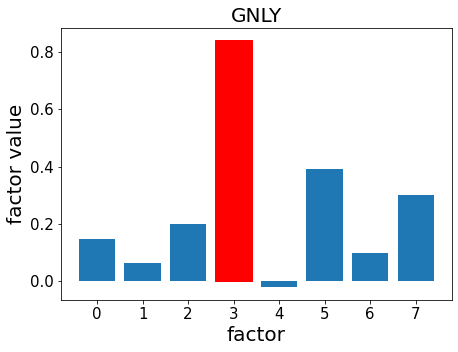

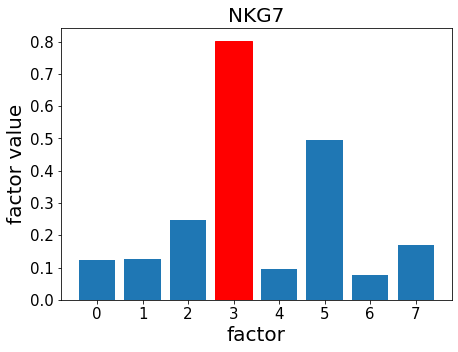

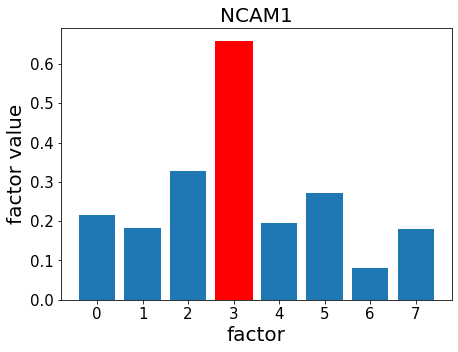

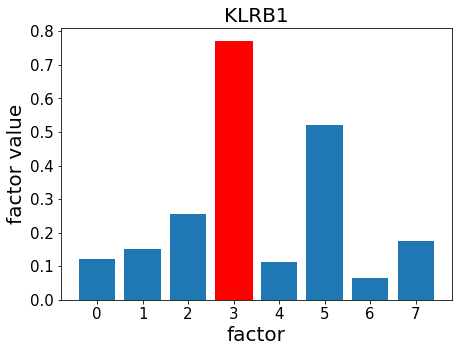

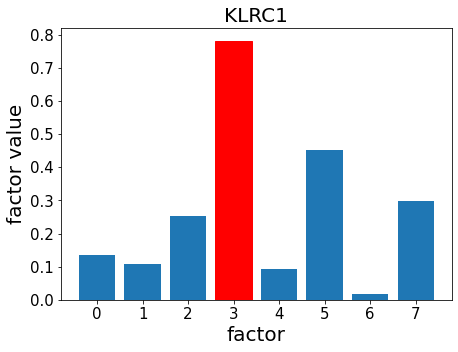

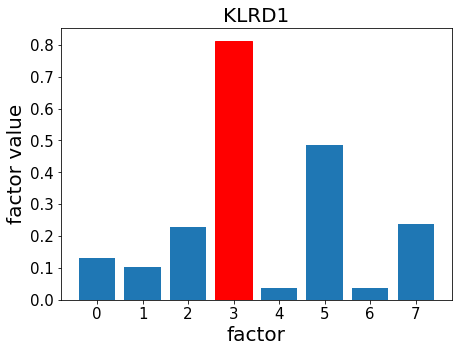

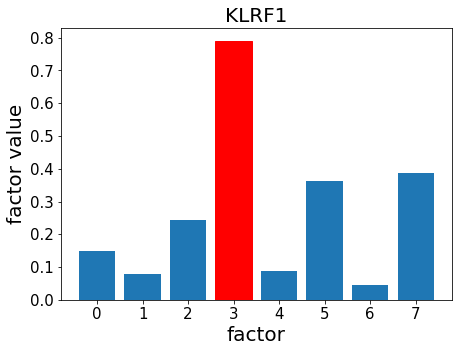

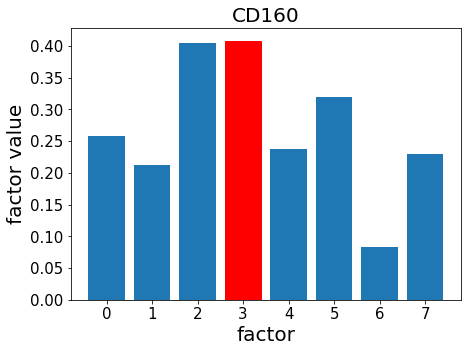

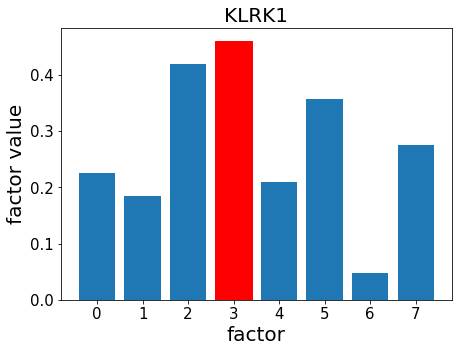

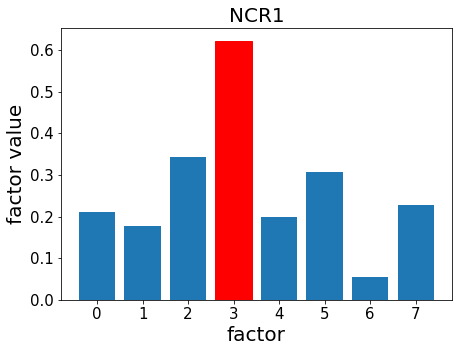

In [44]:
marker = "GNLY"
cluster = 3
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)


marker = "NKG7"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "NCAM1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "KLRB1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "KLRC1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "KLRD1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "KLRF1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "CD160"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "KLRK1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "NCR1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)


### Check marker genes of B cells (Cluster 4)

* **CD79A**,B cells,B cells,This gene encodes the Ig-alpha protein of the B-cell antigen component.
* **CD19**,B cells,B cells,Expression of this cell surface protein is restricted to B cell lymphocytes. This protein is a reliable marker for pre-B cells but its expression diminishes during terminal B cell differentiation in antibody secreting plasma cells.
* **MS4A1**,B cells,B cells,This gene encodes a B-lymphocyte surface molecule which plays a role in the development and differentiation of B-cells into plasma cells.
* **CD79B**,B cells,B cells,This gene encodes the Ig-beta protein of the B-cell antigen component.
* **BLNK**,B cells,B cells,This gene encodes a cytoplasmic linker or adaptor protein that plays a critical role in B cell development. This protein bridges B cell receptor-associated kinase activation with downstream signaling pathways, thereby affecting various biological functions.
* **CD37**,B cells,B cells,"CD37 (tetraspanin TSPAN26) is a B-cell surface antigen widely expressed on mature B cells, is a peripheral mature B-Cell marker.

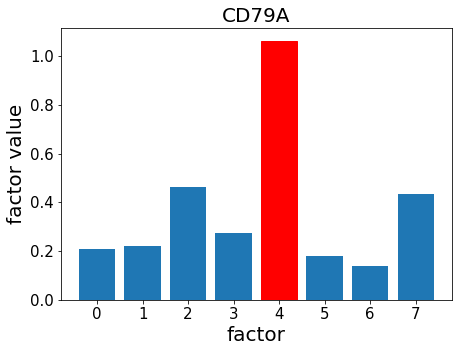

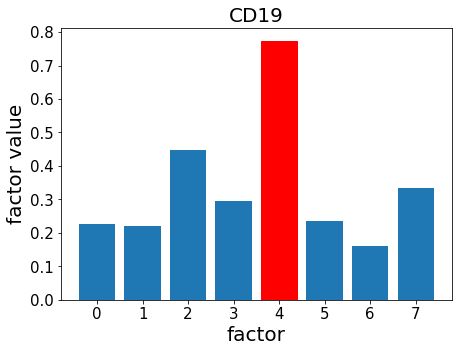

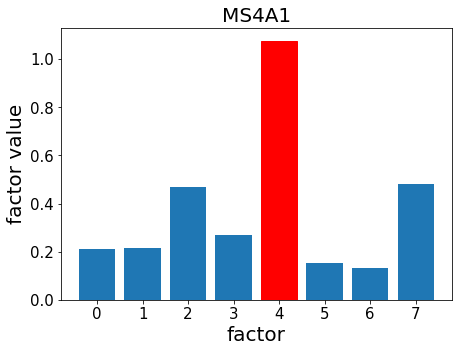

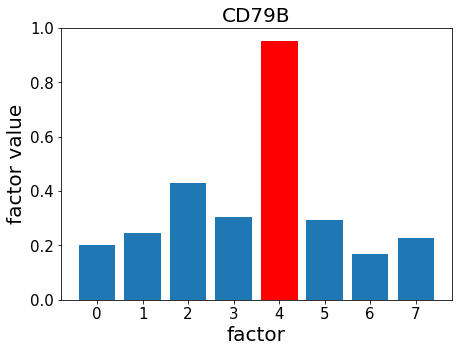

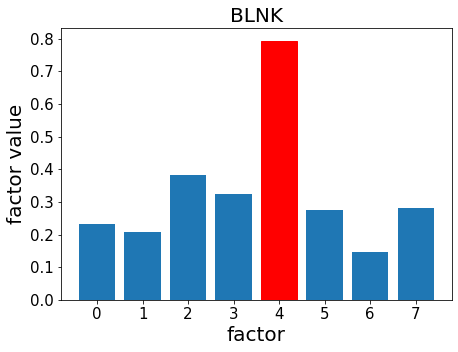

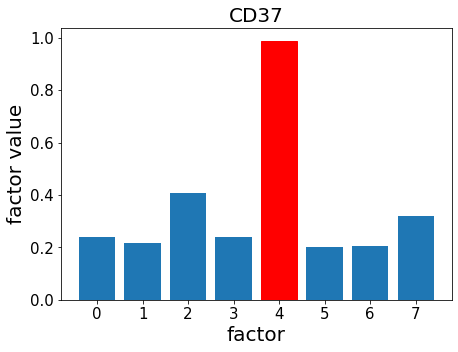

In [45]:
marker = "CD79A"
cluster = 4
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)


marker = "CD19"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "MS4A1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "CD79B"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "BLNK"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "CD37"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

### Check marker genes of Myeloid cells (Cluster 6)

* **CCL2**,CD14+ monocytes,Myeloid cells,CD14+ monocytes from GCF secreted higher levels of CCL2 and showed elevated expression of genes responsible for monocyte migration.
* **S100A8**,CD14+ monocytes,Myeloid cells,Expression is highly induced in CD14(+) monocytes, neutrophils, and developing neutrophils of patients infected by SARS-COV-2
* **S100A9**,CD14+ monocytes,Myeloid cells,We have identified members of the S100 protein family – S100A8, S100A9 and S100A12 – specifically expressed in CD14+ HLA-DR−/low myeloid-derived suppressor cells(MDSC).
* **CD14**,CD14+ monocytes,Myeloid cells,The protein encoded by this gene is a surface antigen that is preferentially expressed on monocytes/macrophages.
* **LYZ**,CD14+ monocytes,Myeloid cells,Lysozymes have primarily a bacteriolytic function; those in tissues and body fluids are associated with the monocyte-macrophage system and enhance the activity of immunoagents.
* **LGALS3**,CD14+ monocytes,Myeloid cells,Involved in acute inflammatory responses including neutrophil activation and adhesion, chemoattraction of monocytes macrophages, opsonization of apoptotic neutrophils, and activation of mast cells.
* **S100A12**,CD14+ monocytes,Myeloid cells,Acts as a monocyte and mast cell chemoattractant.
* **VMO1**,CD16+ monocytes,Myeloid cells,Vitelline 

* **MS4A7**,FCGR3A+ monocytes,Myeloid cells,This gene encodes a member of the membrane-spanning 4A gene family. This family member is associated with mature cellular function in the monocytic lineage, and it may be a component of a receptor complex involved in signal transduction. 

* **IL3RA**,Plasmacytoid dendritic cells,Myeloid cells,The protein encoded by this gene is an interleukin 3 specific subunit of a heterodimeric cytokine receptor.

* **NRP1**,Plasmacytoid dendritic cells,Myeloid cells,This gene encodes one of two neuropilins, which contain specific protein domains which allow them to participate in several different types of signaling pathways that control cell migration.

* **PPBP**,Macrophages,Myeloid cells,Among its related pathways are CCR5 Pathway in Macrophages and GPCR Pathway.
* **CD68**,Macrophages,Myeloid cells,This gene encodes a 110-kD transmembrane glycoprotein that is highly expressed by human monocytes and tissue macrophages.

* **CSF1R**,Macrophages,Myeloid cells,The protein encoded by this gene is the receptor for colony stimulating factor 1, a cytokine which controls the production, differentiation, and function of macrophages

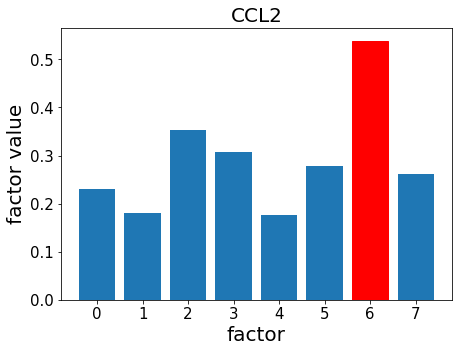

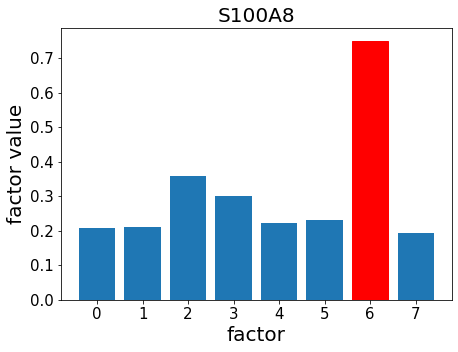

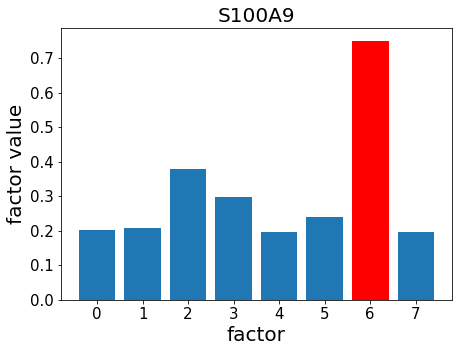

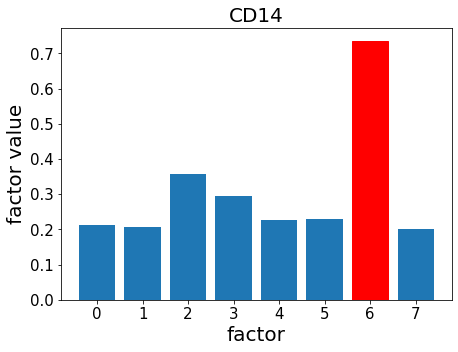

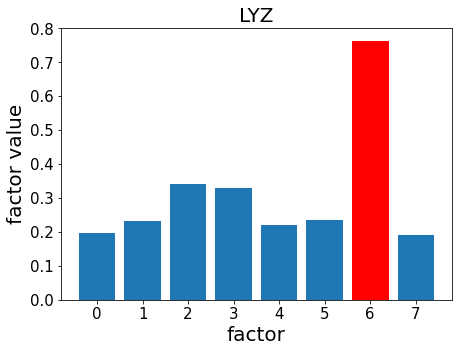

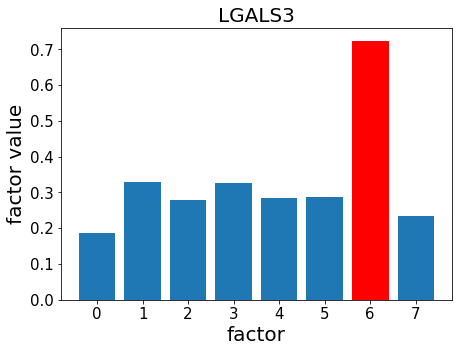

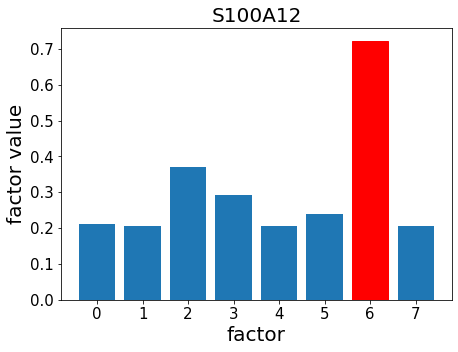

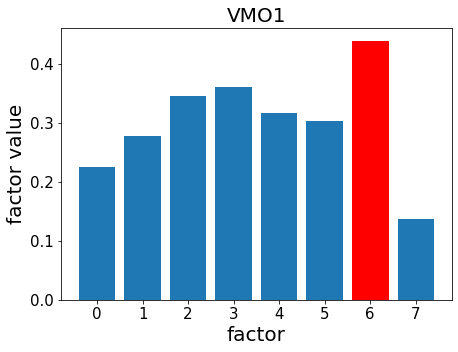

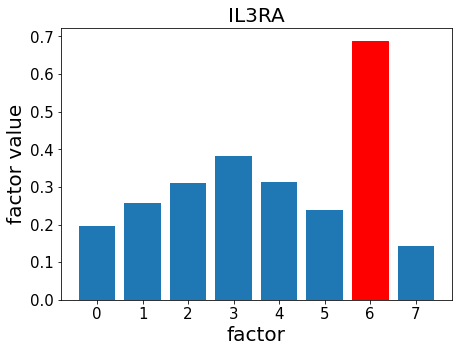

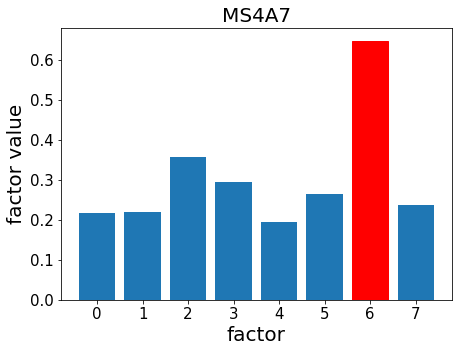

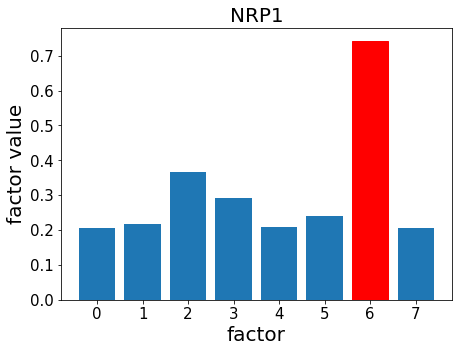

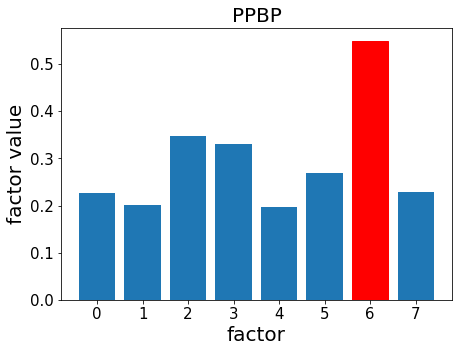

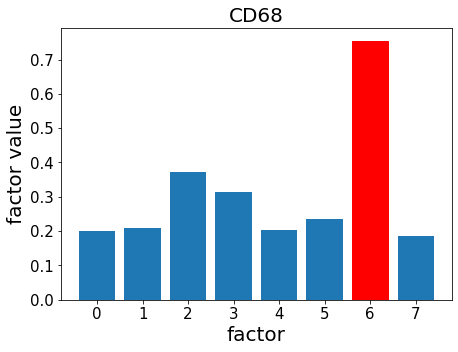

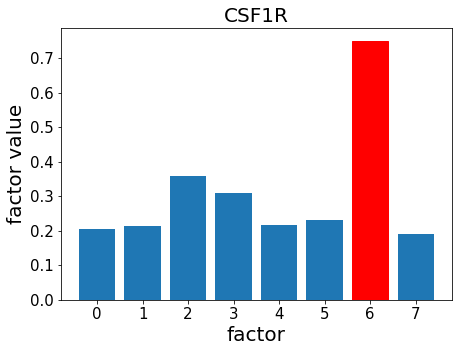

In [52]:
marker = "CCL2"
cluster = 6
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)


marker = "S100A8"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "S100A9"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "CD14"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "LYZ"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "LGALS3"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "S100A12"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "VMO1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "IL3RA"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "MS4A7"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "NRP1"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)


marker = "PPBP"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)

marker = "CD68"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)


marker = "CSF1R"
x = C_gene.iloc[np.where(genes == marker)[0][0],:].values.squeeze()

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(8), x)
barlist[cluster].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(marker, fontsize = 20)
_ = ax.set_xticks(np.arange(8))
_ = ax.set_xticklabels(np.arange(8))
_ = ax.set_xlabel("factor", fontsize = 20)
_ = ax.set_ylabel("factor value", fontsize = 20)



## T cells